In [42]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf

from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber, LogCosh

In [43]:
def load_dataset(up_to= None):
    '''
    Charge les fichiers DVF jusqu'à une année donnée (incluse).

    Paramètres:
        up_to (str): Année maximale à charger, ex: "2020", "2023".

    Return:
        DataFrame Pandas combiné sans doublons.
    '''

    data_files = {
        "2019": "data/ValeursFoncieres-2019-S2.txt",
        "2020": "data/ValeursFoncieres-2020.txt",
        "2021": "data/ValeursFoncieres-2021.txt",
        "2022": "data/ValeursFoncieres-2022.txt",
        "2023": "data/ValeursFoncieres-2023.txt",
        "2024": "data/ValeursFoncieres-2024-S1.txt",
    }

    valid_years = list(data_files.keys())
    if (up_to is not None) and (up_to not in valid_years):
        print("Erreur: \"up_to\" doit être une année entre \"2019\" et \"2024\".")
        return -1

    data_list = []
    for year, path in data_files.items():
        print(f"Chargement {year}...")
        df = pd.read_csv(path, delimiter='|', dtype= str)
        data_list.append(df)
        if (up_to is not None) and (year == up_to):
            break

    data = pd.concat(data_list, ignore_index= True)
    # data.drop_duplicates(inplace=True) #? Fait crash le kernel, désactivé pour le moment
    print(f"\n{len(data):,} lignes chargées au total.")

    return data

def parse_dataset(dataset, min_price= 1_000, max_price= 2_000_000):
    '''
    Parsing des données, on ne garde que les lignes des ventes et de certains types de local.
    Seule les colonnes suivantes sont gardées : "Valeur fonciere", "Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales".
    Les lignes comportant des NaN sont supprimées.
    Ajout de colonnes pour "Année", "Mois", "Jour".
    Valeurs de target plafonnée.

    Paramètres:
        dataset (dataset): strucutre d'un fichier DVF.
        max_price (float): valeur maximum de target.

    Retour:
        dataFrames Pandas, X contenant les features et y contenant la target.
    '''

    if max_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price < 0:
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if min_price >= max_price:
        print("Erreur: \"min_price\" doit être < à \"max_price\"")
        return -1

    dataset = dataset[(dataset["Nature mutation"] == "Vente")]

    dataset = dataset.dropna(subset= ["Date mutation", "Valeur fonciere", "Code departement", "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain", "Code postal"])
    dataset["Valeur fonciere"] = dataset["Valeur fonciere"].str.replace(",", ".", regex= False).astype(float)
    dataset["Date mutation"] = pd.to_datetime(dataset["Date mutation"], format="%d/%m/%Y", errors="coerce")
    # dataset["Annee"] = dataset["Date mutation"].dt.year
    dataset["Mois"] = dataset["Date mutation"].dt.month
    # dataset["Jour"] = dataset["Date mutation"].dt.day
    dataset["Surface reelle bati"] = dataset["Surface reelle bati"].str.replace(",", ".", regex= False).astype(float)
    dataset["Nombre pieces principales"] = dataset["Nombre pieces principales"].astype(int)
    dataset["Surface terrain"] = dataset["Surface terrain"].str.replace(",", ".", regex= False).astype(float)
    dataset["Code postal"] = dataset["Code postal"].astype(str)

    dataset["Prix au m2"] = dataset["Valeur fonciere"] / dataset["Surface reelle bati"]
    # dataset["Ratio surface terrain bati"] = dataset["Surface terrain"] / dataset["Surface reelle bati"]
    # dataset["Ratio pieces surface bati"] = dataset["Nombre pieces principales"] / dataset["Surface reelle bati"]

    freq_cp = dataset["Code postal"].value_counts()
    dataset["Frequence CP"] = dataset["Code postal"].map(freq_cp)

    dataset = dataset[(dataset["Type local"] == "Maison") | (dataset["Type local"] == "Appartement")]
    dataset = dataset[(dataset["Valeur fonciere"] >= min_price) &
                (dataset["Valeur fonciere"] <= max_price) &
                (dataset["Surface reelle bati"] >= 15) &
                (dataset["Surface reelle bati"] <= 300) &
                (dataset["Surface terrain"] <= 10_00) &
                (dataset["Nombre pieces principales"] >= 1) &
                (dataset["Nombre pieces principales"] <= 12)
                # (dataset["Prix au m2"] >= 300) &
                # (dataset["Prix au m2"] <= 10_000)
                ]
    features = ["Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Mois", "Frequence CP"]
    target = "Valeur fonciere"

    return dataset, features, target

def visualize_dataset(data, min_price= 10_000, max_price= 2_000_000):

    # dataset, features, target = parse_dataset(data, min_price= 0, max_price= 100_000_000)
    dataset, features, target = parse_dataset(data, min_price= 10_000, max_price= 2_000_000)
    X = dataset[features]
    print("Shape des features:", X.shape)
    print("Colonnes:", X.columns.tolist())
    print("\nAperçu des données:")
    display(X.head())
    print("\nRésumé statistique des variables numériques:")
    display(X.describe())
    print("\nRépartition des types de biens:")
    print(X["Type local"].value_counts())

    plt.figure(figsize= (20, 6))
    for type_local in dataset["Type local"].unique():
        subset = dataset[dataset["Type local"] == type_local]
        plt.scatter(subset["Date mutation"], subset["Valeur fonciere"], label= type_local, alpha= .2, s= 1)
    plt.title("Ventes à différentes dates")
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.xlabel("Date de vente")
    plt.ylabel("Valeur foncière (€)")
    plt.yscale("log")
    plt.grid(True, which= "both")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (10, 6))
    for type_local in dataset["Type local"].unique():
       subset = dataset[dataset["Type local"] == type_local]
       plt.hist(subset["Valeur fonciere"], label= type_local, alpha= .5, bins= 200, log= False, density= False)
    plt.hist(dataset["Valeur fonciere"], label= "Total", bins= 200, log= False, density= False, histtype= "step", color = 'k')
    plt.title("Distribution des valeurs foncière")
    plt.xlabel("Valeur foncière (€)")
    plt.ylabel("Nombre de ventes")
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.show()

    plt.figure(figsize= (10, 6))
    for type_local in dataset["Type local"].unique():
        subset = dataset[dataset["Type local"] == type_local]
        plt.scatter(subset["Surface reelle bati"], subset["Valeur fonciere"], label= type_local, alpha= .1, s= 1)
    plt.title("Valeur foncière en fonction de la surface du bâtiement")
    plt.xlabel("Surface réelle (m²)")
    plt.ylabel("Valeur foncière (€)")
    plt.grid(True)
    plt.legend(loc= "upper right", title= "Type de bien")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (20, 6))
    plt.scatter(dataset["Code departement"], dataset["Prix au m2"], s= 1)
    for departement in dataset["Code departement"].unique():
        subset = dataset[dataset["Code departement"] == departement]
        plt.errorbar(departement, np.mean(subset["Prix au m2"]), yerr= np.std(subset["Prix au m2"], ddof= 1), c= "k", capsize= 6)
    plt.title("Distribution du prix au m² par département")
    plt.xlabel("Code département")
    plt.ylabel("Prix au m² (€)")
    plt.xticks(rotation= 45)
    plt.yscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize= (10, 6))
    seaborn.heatmap(dataset.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matrice de corrélation des variables numériques")
    plt.tight_layout()
    plt.show()

    return

def process_features(X):
    '''
    Normalise et classifie X.

    Paramètres:
        X (Dataframe): DataFrame contenant les features.

    Retour:
        La DataFrame d'entrée avec ses valeurs processées.
    '''

    categorical_features = ["Code departement", "Type local"]
    numeric_features = ["Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Mois", "Frequence CP"]
    preprocessor = ColumnTransformer(transformers= [(
        'num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown= 'ignore'), categorical_features)
        ])
    X_processed = preprocessor.fit_transform(X)

    return X_processed

In [44]:
def create_tf_dataset(X, y, batch_size= 2048):
    '''
    Create a tf.data.dataset for GPU usage.

    Parametres:
    Retour:
    '''
    X_array = X.toarray()
    dataset = tf.data.Dataset.from_tensor_slices((X_array, y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

    return dataset

def handle_dataset(dataset, features, target, sampled= True, sample_size= 1e5, log= True):
    X, y = dataset[features], dataset[target]

    if sampled is True:
        X_sampled = X.sample(n= int(sample_size))
        y_sampled = y.loc[X_sampled.index]
        X_processed = process_features(X_sampled)
        y = y_sampled
    else:
        X_processed = process_features(X)

    if log is True:
        y = np.log1p(y)

    X_temp, X_test, y_temp, y_test = train_test_split(X_processed, y, test_size= .2)
    X_train, X_vali, y_train, y_vali = train_test_split(X_temp, y_temp, test_size= .2)

    return X_train, X_vali, X_test, y_train, y_vali, y_test

In [4]:
data = load_dataset(up_to= "2021") #TODO crash toujour lorsque load au dessus de 2021

Chargement 2019...
Chargement 2020...
Chargement 2021...

10,162,527 lignes chargées au total.


In [5]:
# visualize_dataset(data, min_price= 10_000, max_price= 2_000_000)

In [6]:
dataset, features, target = parse_dataset(data, min_price= 10_000, max_price= 1_000_000)

In [33]:
X_train, X_vali, X_test, y_train, y_vali, y_test = handle_dataset(
    dataset,
    features,
    target,
    sampled= True,
    sample_size= 100_000,
    log= True,
)
print(f"Input shape: {X_train.shape}")
print(f"Output shape: {y_train.shape}")

Input shape: (64000, 104)
Output shape: (64000,)


# Clustering

In [45]:
def plot_elbow_method(X, k_max= 10):
    '''
    Affiche le diagramme du coude (inertie en fonction du nombre de clusters k).
    
    Paramètres:
        X (DataFrame): données brutes.
        k_max (int): nombre maximum de clusters testés.

    Retour:
        None
    '''

    sample_indices = np.random.choice(X.shape[1], size= 10_000)
    X_sampled = X[sample_indices]
    inertias = []
    ks = np.arange(2, k_max + 2)

    for k in tqdm(ks):
        kmeans = KMeans(n_clusters= k, n_init= "auto", random_state= 42)
        kmeans.fit(X_sampled)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize= (10, 4))
    plt.plot(ks, inertias, marker= "o", ls= "--", color= "r")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Inertie intra-cluster")
    plt.title("Elbow methode pour choisir K")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

def plot_silhouette_scores(X, k_max= 10):
    '''
    Affiche le score de silhouette en fonction du nombre de clusters k.

    Paramètres:
        X (DataFrame): données brutes.
        k_max (int): nombre max de clusters testés.

    Retour:
        None
    '''

    sample_indices = np.random.choice(X.shape[1], size= 10_000)
    X_sampled = X[sample_indices]
    silhouette_scores = []
    ks = np.arange(2, k_max + 2)

    for k in tqdm(ks):
        kmeans = KMeans(n_clusters= k, n_init= "auto")
        labels = kmeans.fit_predict(X_sampled)
        score = silhouette_score(X_sampled, labels)
        silhouette_scores.append(score)

    plt.figure(figsize= (10, 4))
    plt.plot(ks, silhouette_scores, marker= "o", ls= "--", color= "r")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Score de silhouette")
    plt.title("Score de silhouette pour différents k")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

100%|██████████| 99/99 [03:42<00:00,  2.25s/it]


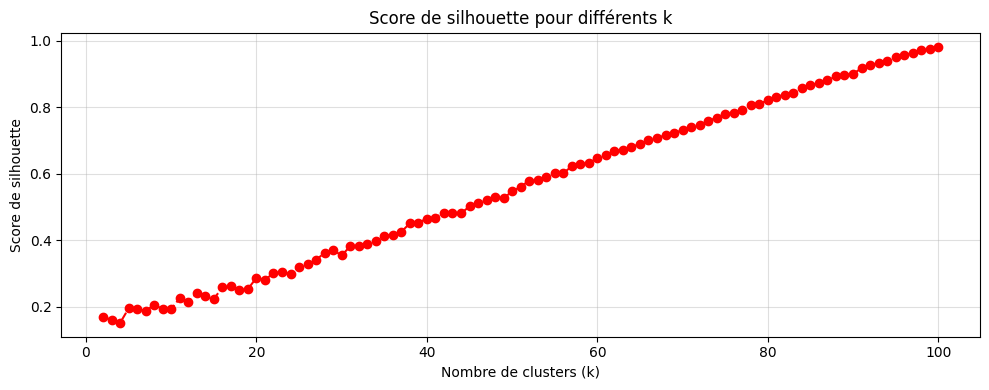

In [38]:
plot_silhouette_scores(X_train, 100)

100%|██████████| 100/100 [00:06<00:00, 14.46it/s]


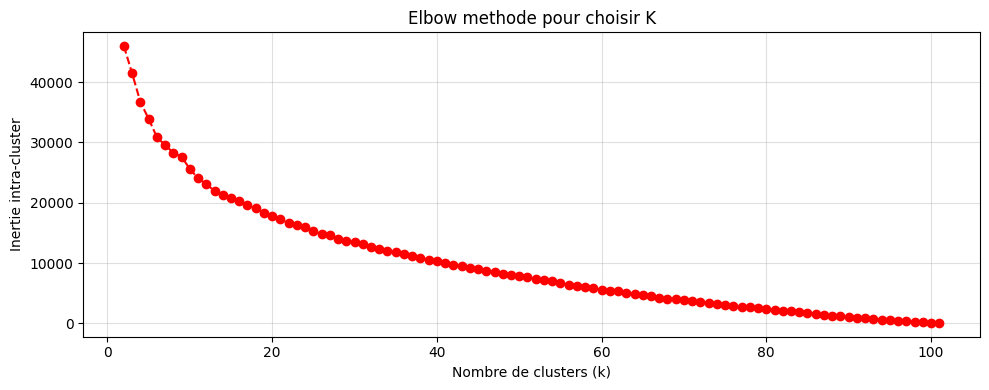

In [46]:
plot_elbow_method(X_train, 100)

In [47]:
k = 100
kmeans = KMeans(n_clusters= k)
cluster_labels = kmeans.fit_predict(X_train)

print("Inertie :", kmeans.inertia_)
# print("Silhouette score :", silhouette_score(X_train, cluster_labels))

Inertie : 109547.3751317873


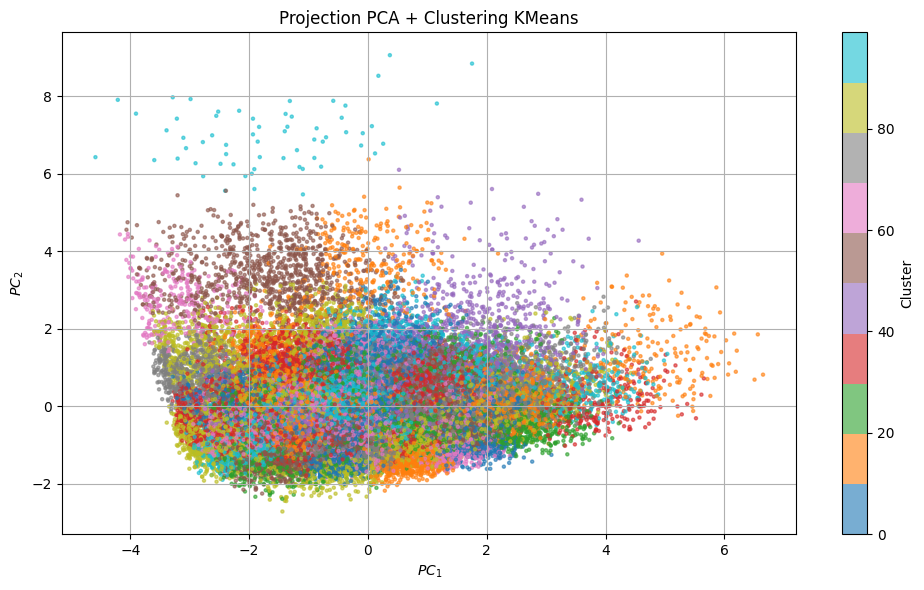

In [48]:
pca = PCA(n_components= 2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="tab10", s=5, alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.title("Projection PCA + Clustering KMeans")
plt.xlabel(r"$PC_1$")
plt.ylabel(r"$PC_2$")
plt.grid(True)
plt.tight_layout()
plt.show()

| Cluster | Type Local | Département | Terrain (m²) - Moy | Terrain - Écart | Bâti (m²) - Moy | Bâti - Écart | Pièces - Moy | Pièces - Écart | Freq CP | Mois | Prix Moyen (€) | Écart | Max |
|--------:|------------|-------------|--------------------|------------------|------------------|--------------|---------------|----------------|---------|------|-----------------|--------|--------|
| 0 | Maison | 59 | 242.52 | 185.26 | 47.83 | 17.05 | 2.07 | 0.77 | 905.99 | 7.63 | 193,119.41 | 175,484.35 | 1,000,000 |
| 1 | Maison | 59 | 308.73 | 149.79 | 94.05 | 21.38 | 4.17 | 0.83 | 790.82 | 9.56 | 211,551.80 | 143,575.12 | 1,000,000 |
| 2 | Maison | 33 | 775.53 | 141.33 | 94.55 | 24.44 | 3.96 | 0.97 | 788.61 | 8.83 | 223,800.52 | 143,374.86 | 1,000,000 |
| 3 | Maison | 59 | 275.87 | 196.13 | 74.43 | 33.07 | 3.42 | 1.40 | 3,665.19 | 7.54 | 238,138.49 | 167,025.19 | 1,000,000 |
| 4 | Maison | 59 | 584.64 | 224.45 | 162.56 | 35.95 | 6.11 | 1.16 | 870.92 | 7.54 | 335,318.97 | 194,951.81 | 1,000,000 |
| 5 | Maison | 59 | 435.86 | 224.34 | 93.16 | 24.42 | 4.05 | 0.96 | 817.61 | 3.00 | 209,537.21 | 143,099.72 | 1,000,000 |


Clustering pas concluant, des clusters non humain et centrés sur le 59...

# PCA

In [51]:
def plot_explained_variance(X, n_components= 10):
    '''
    Affiche la variance expliquée cumulée pour une PCA de n_components sur les données d'entrée.

    Paramètres:
        X (DataFrame): données d'entrée.
        n_components (int): nombre de composantes principales à conserver.

    Retour:
        None
    '''

    pca = PCA(n_components= n_components)
    pca.fit(X)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    n = np.arange(1, len(cumulative_variance) + 1)

    plt.figure(figsize= (8, 4))
    plt.plot(n, cumulative_variance, marker= "o", color= "r", ls= "--")
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Variance expliquée cumulée")
    plt.title("Variance expliquée cumulée par PCA")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

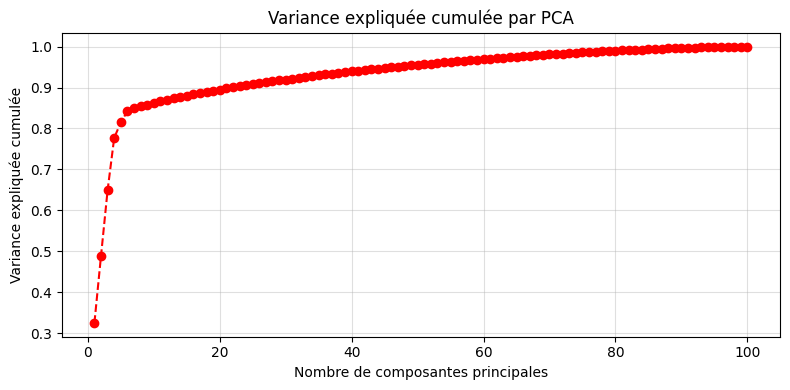

In [52]:
plot_explained_variance(X_train, 100)

In [53]:
pca = PCA(10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

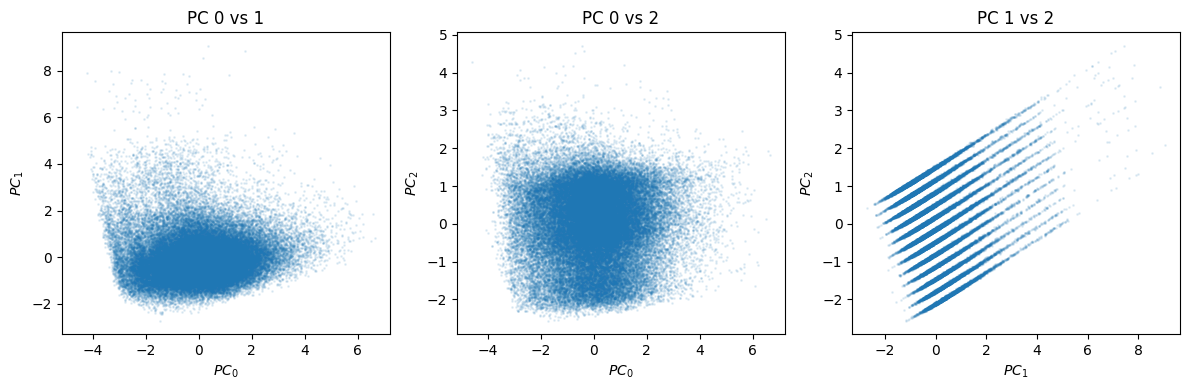

In [54]:
plt.figure(figsize= (12, 4))

plt.subplot(131)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], s= 1, alpha= .1)
plt.xlabel(r"$PC_0$")
plt.ylabel(r"$PC_1$")
plt.title("PC 0 vs 1")

plt.subplot(132)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 2], s= 1, alpha= .1)
plt.xlabel(r"$PC_0$")
plt.ylabel(r"$PC_2$")
plt.title("PC 0 vs 2")

plt.subplot(133)
plt.scatter(X_train_pca[:, 1], X_train_pca[:, 2], s= 1, alpha= .1)
plt.xlabel(r"$PC_1$")
plt.ylabel(r"$PC_2$")
plt.title("PC 1 vs 2")

plt.tight_layout()
plt.show()

# Random Forest

In [65]:
def evaluate_rf_params(X_train, X_test, y_train, y_test):

    sample_indices = np.random.choice(X_train.shape[1], size= 10_000)
    X_train_sampled = X_train[sample_indices]
    X_test_sampled = X_test[sample_indices]
    y_train_sampled = y_train[sample_indices]
    y_test_sampled = y_test[sample_indices]

    r2_max = 0
    n_max, m_max = 0, 0
    for n in tqdm(range(10, 105, 5)):
        for m in range(15, 105, 5):
            model = RandomForestRegressor(n_estimators= n, max_depth= m, n_jobs= -1, random_state= 42)
            model.fit(X_train_sampled, y_train_sampled)
            y_pred = model.predict(X_test_sampled)
            y_pred_real = np.expm1(y_pred)
            y_test_real = np.expm1(y_test_sampled)
            r2 = r2_score(y_test_real, y_pred_real)
            if r2 > r2_max:
                r2_max = r2
                n_max, m_max = n, m
    print(f"n= {n_max}, m= {m_max}, R²= {r2_max:.2f}")

    return

def show_rf_stats(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred_real = np.expm1(y_pred)
    y_test_real = np.expm1(y_test)

    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = root_mean_squared_error(y_test_real, y_pred_real)
    r2 = r2_score(y_test_real, y_pred_real)
    print(f"MAE : {mae:.2f} €")
    print(f"RMSE : {rmse:.2f} €")
    print(f"R² : {r2:.4f}")

    plt.figure(figsize= (8, 4))
    plt.scatter(y_test_real, y_pred_real, alpha= .3, s= 1)
    plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
    plt.xlabel("Valeur réelle (€)")
    plt.ylabel("Valeur prédite (€)")
    plt.title("Prédictions RF vs Réel")
    plt.grid(True)
    plt.loglog()
    plt.tight_layout()
    plt.show()

    return

In [ ]:
# evaluate_rf_params(X_train, y_train) #TODO à refaire

100%|██████████| 19/19 [1:56:44<00:00, 368.64s/it]

n= 0, m= 0, R²= 0.00


In [56]:
n_estimators = 35
max_depth = 55

In [57]:
rf = RandomForestRegressor(n_estimators= n_estimators, max_depth= max_depth, n_jobs= -1)

In [61]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1)

MAE : 83560.00 €
RMSE : 126983.20 €
R² : 0.4195


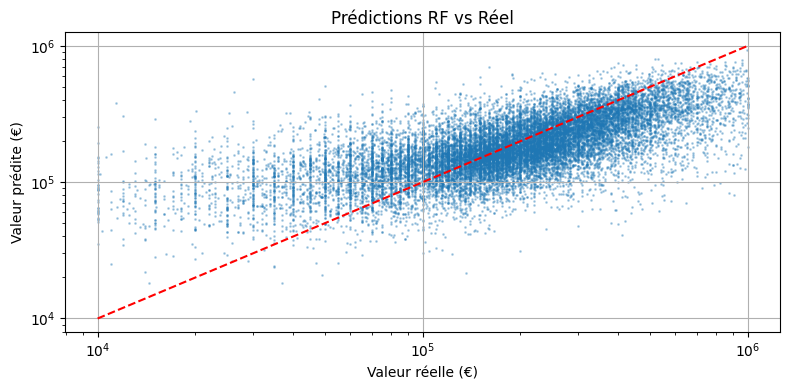

In [66]:
show_rf_stats(X_test, y_test, rf)

# Random Forest \w PCA

In [67]:
rf_pca = RandomForestRegressor(n_estimators= n_estimators, max_depth= max_depth, n_jobs= -1)

In [68]:
rf_pca.fit(X_train_pca, y_train)

RandomForestRegressor(max_depth=55, n_estimators=35, n_jobs=-1)

MAE : 97395.42 €
RMSE : 146781.15 €
R² : 0.2244


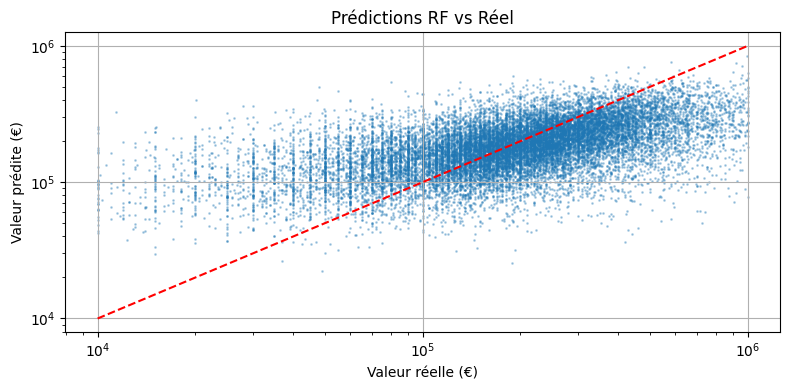

In [70]:
show_rf_stats(X_test_pca, y_test, rf_pca)

# MLP

In [71]:
def create_tf_dataset(X, y, batch_size= 2048):
    '''
    Create a tf.data.dataset for GPU usage.

    Parametres:
    Retour:
    '''
    X_array = X.toarray()
    dataset = tf.data.Dataset.from_tensor_slices((X_array, y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

    return dataset

def show_nn_stats(X_test, y_test, model, model_history):
    y_pred = model.predict(X_test)
    y_pred_real = np.expm1(y_pred)
    y_test_real = np.expm1(y_test)
    lrate = model_history.history["learning_rate"]

    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = root_mean_squared_error(y_test_real, y_pred_real)
    r2 = r2_score(y_test_real, y_pred_real)
    print(model.evaluate(X_test))
    print(f"MAE : {mae:.2f} €")
    print(f"RMSE : {rmse:.2f} €")
    print(f"R² : {r2:.4f}")
    print(f"lrate : [{lrate[0]}, {lrate[-1]}]")

    plt.figure(figsize= (12, 8))
    plt.subplot(211)
    plt.scatter(y_test_real, y_pred_real, alpha= .3, s= 1)
    plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
    plt.xlabel("Valeur réelle (€)")
    plt.ylabel("Valeur prédite (€)")
    plt.title("Prédictions "+ model.name + " vs Réel")
    plt.grid(True)
    plt.loglog()

    plt.subplot(223)
    plt.plot(model_history.history["loss"], label= "training")
    plt.plot(model_history.history["val_loss"], label= "validation")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()

    plt.subplot(224)
    plt.plot(model_history.history["learning_rate"])
    plt.xlabel("epochs")
    plt.ylabel("lrate")
    plt.yscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return

def build_mlp_model(input_shape= 0, n_layers= 3, layer_size= 512, lrate= 1e-3, loss_function= "mse", layer_type= "constant"):

    if loss_function == "mse":
        loss = "mse"
    elif loss_function == "log_cosh":
        loss = LogCosh()
    elif loss_function == "huber":
        loss = Huber(delta= .3)
    else:
        print(f"Error: Unknown loss function, {loss_function}.")
        return -1

    model = Sequential(name= "MLP")
    model.add(Input(shape = (input_shape,)))
    model.add(Dense(layer_size, activation= "relu"))

    if layer_type == "constant":
        for _ in range(n_layers - 1):
            model.add(Dense(layer_size, activation= "relu"))
            model.add(BatchNormalization())
            model.add(Dropout(.3))
    elif layer_type == "shrinking":
        for n in range(1, n_layers - 1):
            model.add(Dense(int(layer_size / (2 ** n)), activation= "relu"))
            model.add(BatchNormalization())
            model.add(Dropout(.3))
    else:
        print(f"Error: Unknown layer type, {layer_type}.")
        return -1

    model.add(Dense(1))

    model.summary()
    model.compile(optimizer= Adam(learning_rate= lrate), loss= loss, metrics= ["mae"])

    return model

def build_resmlp_model(input_shape= 0, n_layers= 1, layer_size= 512, lrate= 1e-3, loss_function= "mse"):

    if loss_function == "mse":
        loss = "mse"
    elif loss_function == "log_cosh":
        loss = LogCosh()
    elif loss_function == "huber":
        loss = Huber(delta= .3)
    else:
        print("Error: Unknown loss function.")
        return -1

    input_layer = Input(shape= (input_shape,))
    x = Dense(layer_size, activation= "relu")(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(.3)(x)
    for _ in range(n_layers - 1):
        x_res = Dense(layer_size, activation= "relu")(x)
        x_res = BatchNormalization()(x_res)
        x_res = Dropout(.3)(x_res)
        x = Add()([x, x_res])
    shortcut = Dense(1)(input_layer)
    main_output = Dense(1)(x)
    output_layer = Add()([main_output, shortcut])
    # output_layer = Dense(1)(x)

    model = Model(inputs= input_layer, outputs= output_layer, name= "resMLP")
    model.summary()
    model.compile(optimizer= Adam(learning_rate= lrate), loss= loss, metrics= ["mae"])

    return model

In [83]:
X_train, X_vali, X_test, y_train, y_vali, y_test = handle_dataset(
    dataset,
    features,
    target,
    sampled= True,
    sample_size= 5e5,
    log= True,
)

In [84]:
batch_size= 4096
epochs= 200
input_shape = X_train.shape[1]

dataset_test = create_tf_dataset(X_test, y_test, batch_size)
dataset_train = create_tf_dataset(X_train, y_train, batch_size)
dataset_vali = create_tf_dataset(X_vali, y_vali, batch_size)

In [127]:
mlp = build_mlp_model(
    input_shape= input_shape,
    n_layers= 3,
    layer_size= 512,
    lrate= 1e-3,
    loss_function= "huber",
    layer_type= "shrinking"
)

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_83 (Dense)                │ (None, 512)            │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,369 (728.00 KB)

 Trainable params: 185,857 (726.00 KB)

 Non-trainable params: 512 (2.00 KB)

In [104]:
resmlp = build_resmlp_model(
    input_shape= input_shape,
    n_layers= 4,
    layer_size= 512,
    lrate= 1e-3,
    loss_function= "huber"
)

Model: "resMLP"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 104)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 512)       │     53,760 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_60[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 512)       │    262,656 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_61[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 512)       │          0 │ dropout_36[0][0], │
│                     │                   │            │ dropout_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 512)       │    262,656 │ add_19[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_62[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 512)       │          0 │ add_19[0][0],     │
│                     │                   │            │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 512)       │    262,656 │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_63[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 512)       │          0 │ add_20[0][0],     │
│                     │                   │            │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 1)         │        513 │ add_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 1)         │        105 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 1)         │          0 │ dense_65[0][0], 

 Total params: 850,538 (3.24 MB)

 Trainable params: 846,442 (3.23 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [128]:
nn_model = mlp
# nn_model = resmlp

In [129]:
early_stop = EarlyStopping(patience= 10, restore_best_weights= True)
lr_scheduler = ReduceLROnPlateau(monitor= 'val_loss', factor= .5, patience= 5, min_lr= 1e-8)

history = nn_model.fit(
    dataset_train,
    validation_data= dataset_vali,
    epochs= epochs,
    callbacks= [early_stop, lr_scheduler],
    verbose= 2
)

Epoch 1/200
79/79 - 4s - 56ms/step - loss: 3.1662 - mae: 10.7039 - val_loss: 2.4607 - val_mae: 8.3524 - learning_rate: 1.0000e-03
Epoch 2/200
79/79 - 0s - 4ms/step - loss: 1.2300 - mae: 4.2474 - val_loss: 0.1254 - val_mae: 0.5479 - learning_rate: 1.0000e-03
Epoch 3/200
79/79 - 0s - 4ms/step - loss: 0.3741 - mae: 1.3885 - val_loss: 0.1062 - val_mae: 0.4810 - learning_rate: 1.0000e-03
Epoch 4/200
79/79 - 0s - 4ms/step - loss: 0.2443 - mae: 0.9517 - val_loss: 0.1103 - val_mae: 0.4974 - learning_rate: 1.0000e-03
Epoch 5/200
79/79 - 0s - 4ms/step - loss: 0.1855 - mae: 0.7534 - val_loss: 0.1115 - val_mae: 0.5031 - learning_rate: 1.0000e-03
Epoch 6/200
79/79 - 0s - 4ms/step - loss: 0.1618 - mae: 0.6734 - val_loss: 0.0977 - val_mae: 0.4537 - learning_rate: 1.0000e-03
Epoch 7/200
79/79 - 0s - 4ms/step - loss: 0.1513 - mae: 0.6381 - val_loss: 0.0998 - val_mae: 0.4614 - learning_rate: 1.0000e-03
Epoch 8/200
79/79 - 0s - 4ms/step - loss: 0.1467 - mae: 0.6227 - val_loss: 0.0937 - val_mae: 0.4388 - 

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0810 - mae: 0.3915
[0.0810018926858902, 0.3916953504085541]
MAE : 78200.98 €
RMSE : 119337.21 €
R² : 0.4752
lrate : [0.0010000000474974513, 6.25000029685907e-05]


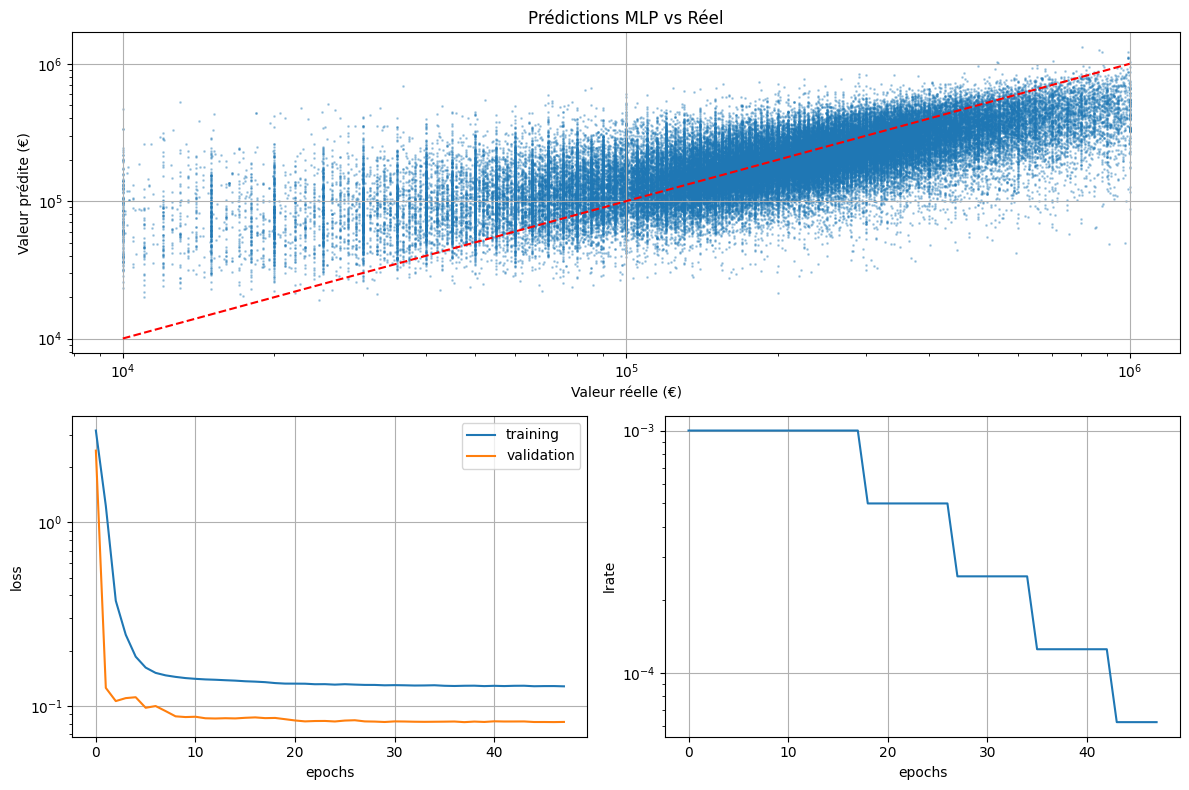

In [130]:
show_nn_stats(dataset_test, y_test, nn_model, history)